In [1]:
using DrWatson
@quickactivate("Hierarchical_Infer_Spikes")

using Turing, CSV, StatsPlots, DataFrames, Distributions, Random, LinearAlgebra

# read in the data table
data = CSV.File(datadir("exp_raw","spikes_in_zones.csv"),header=1)|> DataFrame
data[!,"zones"] = [findfirst(isequal(d),["other","delay","choice","reward3","reward4"]) for d in data.zones]
data[data[!,"zones"].==5,"zones"] .= 4 
data[!,"animal"] = [findfirst(isequal(d),[2443,2453,2454,2462,2467,2486,149]) for d in data.animal]
data = data |> Matrix;

Let each animal $a$ have a mean spike rate $\rho_a$. First, we assume that each day is independent of all the others. When the animal enters zone $z$, the mean spike rate is perturbed systematically by a term $\eta_{z}$ that is common to each zone across animals as
$$S_{a,z} \sim P(\eta_z\rho_a)$$

In [2]:
@model function SpikeZonesPoisson(y,data,A,Z)
    N = length(y)
    observed_animal = data[:,1]
    observed_zone = data[:,3]
    # Priors
    ρ ~ product_distribution([LogNormal(-1,0.3) for i in 1:A]) # mean spike rate per animal
    η ~ MvLogNormal(zeros(Z),I)
    
    # Likelihood
    for i in 1:N
        ρ_a = ρ[Int(observed_animal[i])]
        η_z = η[Int(observed_zone[i])]
        y[i] ~ Poisson(data[i,5]*(ρ_a*η_z)) 
    end

    return y
end

@model function SpikeZonesPoisson_nozone(y,data,A,Z)
    N = length(y)
    observed_animal = data[:,1]
    observed_zone = data[:,3]
    # Priors
    ρ ~ product_distribution([LogNormal(-1,0.3) for i in 1:A]) # mean spike rate per animal
    
    # Likelihood
    for i in 1:N
        ρ_a = ρ[Int(observed_animal[i])]
        y[i] ~ Poisson(data[i,5]*(ρ_a)) 
    end

    return y
end

model_poisson = SpikeZonesPoisson(data[:,4],data,7,4)
model_poisson_nozone = SpikeZonesPoisson_nozone(data[:,4],data,7,4)

DynamicPPL.Model{typeof(SpikeZonesPoisson_nozone), (:y, :data, :A, :Z), (), (), Tuple{Vector{Float64}, Matrix{Float64}, Int64, Int64}, Tuple{}, DynamicPPL.DefaultContext}(SpikeZonesPoisson_nozone, (y = [3.0, 9.0, 23.0, 13.0, 13.0, 27.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 1.0, 4.0, 6.0, 1.0, 91.0, 21.0, 30.0, 39.0, 25.0], data = [7.0 1.0 … 3.0 59.7; 7.0 2.0 … 9.0 79.1333333333333; … ; 6.0 4.0 … 39.0 84.9666666666667; 6.0 5.0 … 25.0 38.9666666666667], A = 7, Z = 4), NamedTuple(), DynamicPPL.DefaultContext())

In [3]:
Random.seed!(1234)
chn = sample(model_poisson, NUTS(0.65), MCMCThreads(),1000,4)

┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC C:\Users\Justin\.julia\packages\AbstractMCMC\YrmkI\src\sample.jl:310
Sampling (1 threads)   0%|█                             |  ETA: N/A
┌ Info: Found initial step size
│   ϵ = 0.003125
└ @ Turing.Inference C:\Users\Justin\.julia\packages\Turing\duwEY\src\mcmc\hmc.jl:212
┌ Info: Found initial step size
│   ϵ = 0.00625
└ @ Turing.Inference C:\Users\Justin\.julia\packages\Turing\duwEY\src\mcmc\hmc.jl:212
Sampling (1 threads)  25%|████████                      |  ETA: 0:00:36
Sampling (1 threads)  50%|████████████████              |  ETA: 0:00:13
┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference C:\Users\Justin\.julia\packages\Turing\duwEY\src\mcmc\hmc.jl:212
┌ Info: Found initial step size
│   ϵ = 0.00625
└ @ Turing.Inference C:\Users\Justin\.julia\packages\Turing\duwEY\src\mcmc\hmc.jl:212
Sampling (1 threads)  75%|███████████████████████       |  ETA: 0:00:04
Sampling (1

Chains MCMC chain (1000×23×4 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 4
Samples per chain = 1000
Wall duration     = 11.02 seconds
Compute duration  = 9.18 seconds
parameters        = ρ[1], ρ[2], ρ[3], ρ[4], ρ[5], ρ[6], ρ[7], η[1], η[2], η[3], η[4]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse   ess_bulk   ess_tail      rhat   e ⋯
      Symbol   Float64   Float64   Float64    Float64    Float64   Float64     ⋯

        ρ[1]    0.6151    0.0687    0.0028   586.1803   643.7668    1.0047     ⋯
        ρ[2]    0.3049    0.0347    0.0014   606.9855   697.0223    1.0050     ⋯
        ρ[3]    0.9619    0.1077    0.0045   582.2926   665.6046    1.0045     ⋯
        ρ[4]    0.1361    0.0160    0.0006   623.2192   750.2668    1.0040     ⋯
        ρ

In [4]:
hpd(chn,alpha=0.01)

HPD
  parameters     lower     upper 
      Symbol   Float64   Float64 

        ρ[1]    0.4517    0.7962
        ρ[2]    0.2238    0.3956
        ρ[3]    0.7002    1.2338
        ρ[4]    0.0971    0.1772
        ρ[5]    0.2049    0.3625
        ρ[6]    0.5751    1.0100
        ρ[7]    0.1318    0.2329
        η[1]    0.9981    1.7646
        η[2]    0.6094    1.0766
        η[3]    0.5807    1.1435
        η[4]    1.3887    2.4367


### A posterior predictive check, Figure 4E

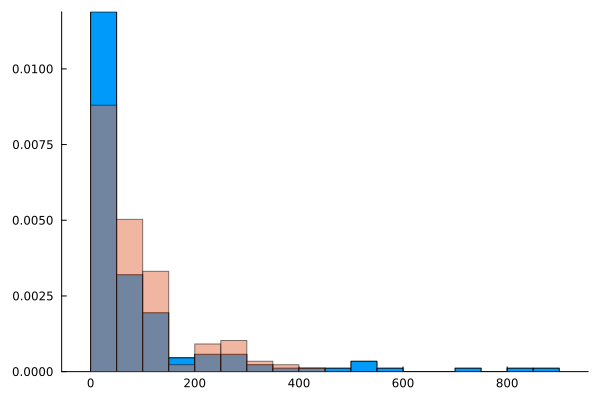

In [5]:
using StatsBase
# https://discourse.julialang.org/t/ann-turing-0-13-0-mle-map-and-prediction/40033
# posterior predictive check
model_test = SpikeZonesPoisson(Vector{Union{Missing, Float64}}(undef, length(data[:,1])),data,7,4)
# first sample some parameters from the posterior
predictions  = predict(model_test,chn)

ys_pred = mean(predictions)[:,2]

histogram(data[:,4],label="Observed",normalize=:pdf)
histogram!(ys_pred,label="Mean of posterior samples",grid=false,alpha=0.5,normalize=:pdf,legend=false)
#savefig("posterior_predictive.svg")

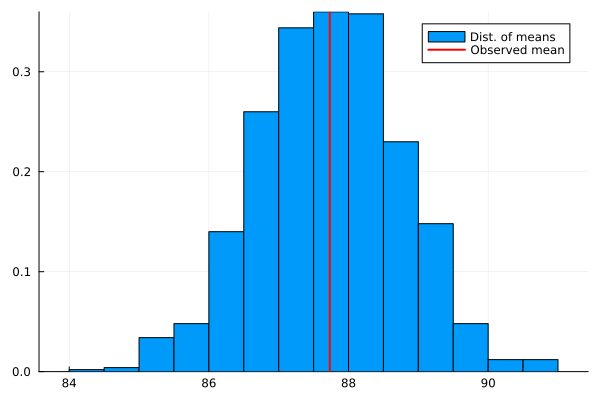

In [6]:
total_sample_means = [mean(vec(predictions[i].value.data[:,:,1])) for i in 1:1000]
histogram(total_sample_means,label="Dist. of means",normalize=:pdf)
vline!([mean(data[:,4])],label="Observed mean",color="red",linewidth=2)

In [7]:
each_animal_posterior_mean = mean(group(chn,:ρ))[:,2]
print(mean(each_animal_posterior_mean), "+/-", 1.96*std(each_animal_posterior_mean)./sqrt(7), "\n")

0.4647853937104096+/-0.23825862988696


In [8]:
chains_nozones = sample(model_poisson_nozone, NUTS(0.65), MCMCThreads(),1000,4)

┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC C:\Users\Justin\.julia\packages\AbstractMCMC\YrmkI\src\sample.jl:310
Sampling (1 threads)   0%|█                             |  ETA: N/A
┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference C:\Users\Justin\.julia\packages\Turing\duwEY\src\mcmc\hmc.jl:212
┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference C:\Users\Justin\.julia\packages\Turing\duwEY\src\mcmc\hmc.jl:212
Sampling (1 threads)  25%|████████                      |  ETA: 0:00:10
Sampling (1 threads)  50%|████████████████              |  ETA: 0:00:03
┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference C:\Users\Justin\.julia\packages\Turing\duwEY\src\mcmc\hmc.jl:212
┌ Info: Found initial step size
│   ϵ = 0.025
└ @ Turing.Inference C:\Users\Justin\.julia\packages\Turing\duwEY\src\mcmc\hmc.jl:212
Sampling (1 threads)  75%|███████████████████████       |  ETA: 0:00:01
Sampling (1 thre

Chains MCMC chain (1000×19×4 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 4
Samples per chain = 1000
Wall duration     = 3.16 seconds
Compute duration  = 2.77 seconds
parameters        = ρ[1], ρ[2], ρ[3], ρ[4], ρ[5], ρ[6], ρ[7]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

        ρ[1]    0.7005    0.0107    0.0001   5649.1900   3463.8430    1.0007   ⋯
        ρ[2]    0.3336    0.0089    0.0001   6124.4464   3332.3929    1.0013   ⋯
        ρ[3]    1.0144    0.0162    0.0002   6131.6708   3383.7826    1.0012   ⋯
        ρ[4]    0.1496    0.0066    0.0001   6177.3290   2944.4430    1.0000   ⋯
        ρ[5]    0.3412    0.0088  

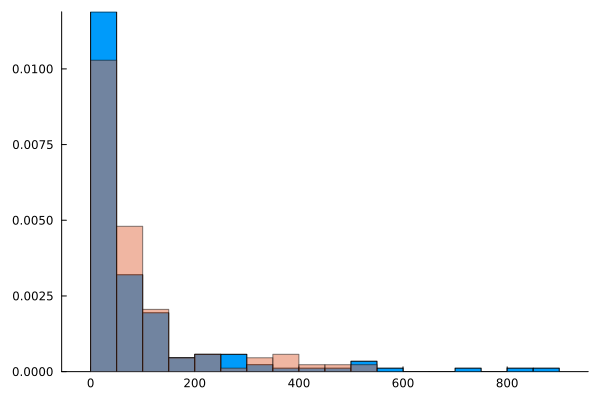

In [9]:
model_test_nozone = SpikeZonesPoisson_nozone(Vector{Union{Missing, Float64}}(undef, length(data[:,1])),data,7,4)
# first sample some parameters from the posterior
predictions_nozone  = predict(model_test_nozone,chains_nozones)

ys_pred_nozones = mean(predictions_nozone)[:,2]

histogram(data[:,4],label="Observed",normalize=:pdf)
histogram!(ys_pred_nozones,label="Mean of posterior samples",grid=false,alpha=0.5,normalize=:pdf,legend=false)

## Model comparisions

### First, MLE

In [11]:
mse_full_model = mean((data[:,4].-ys_pred).^2)
mse_nozone_model = mean((data[:,4].-ys_pred_nozones).^2)

print(mse_full_model, ", ", mse_nozone_model)

13120.960869837145, 15443.191496099282

### Next, AIC

In [47]:
function compute_AIC(mcmdl,mcchn)
    n_params = length(names(mcchn,:parameters))
    mle = maximum_likelihood(mcmdl;lb=zeros(n_params),ub=ones(n_params).*1000)
    return -2*mle.lp + 2*n_params 
end

full_AIC = compute_AIC(model_poisson,chn)
nozone_AIC = compute_AIC(model_poisson_nozone,chains_nozones)

print(full_AIC, ", ", nozone_AIC)

13048.965979184155, 14811.947862540868

# Final output, Figure 4D, panel D

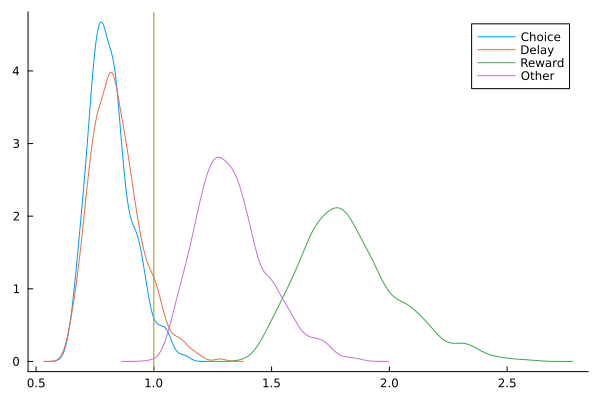

In [19]:
density(chn[:,9,1],label="Choice")
density!(chn[:,10,1],label="Delay")
density!(chn[:,11,1],label="Reward")
density!(chn[:,8,1],label="Other",grid=false,legend=true)
vline!([1],label="")
#savefig(plotsdir("spike_rate_modulation_poisson.svg"))